# Classificação supervisionada com Redes Neurais

<b>Sumário</b>

- Arquitetura de uma rede neural
    - Camadas:
        - Dense
        - Flatten
        - Dropout
        - Conv2D
        - MaxPooling*
    - Funções de ativação
        - ReLu
        - Softmax
- Foward Propagation
- Função de perda
    - log loss*
- Otimizador
- Back Propagation
- Épocas
- Estudo de caso: Iris dataset
    - Experimento 1: Dense(2)+Relu -> Dense(3)+ReLu -> Dense(3)+Softmax com 20 épocas
    - Experimento 2: Dense(20)+Relu -> Dense(30)+ReLu -> Dense(3)+Softmax com 20 épocas
    - Experimento 3: Dense(20)+Relu -> Dense(30)+ReLu -> Dense(3)+Softmax com 200 épocas
- Estudo de caso: MNIST dataset
    - Preparando imagens
    - Batch size*
    - Data augmentation
- Usando GPU no Google Colab

### Bibliotecas e utilidades

In [12]:
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import keras.layers.convolutional as conv
import keras.models as models
import keras.utils.np_utils as kutils
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



def load_preprocess_train_titanic():
    df = pd.read_csv("../datasets/titanic/train.csv")
    del df["Name"]
    df["Sex"] = df["Sex"].apply(lambda x: 0 if x == "male" else 1)
    del df["Ticket"]
    del df["Cabin"]

    def emb(a):
        cases = {"Q": 1, "S": 2, "C": 3}
        if a in cases:
            return cases[a]
        else:
            return 0

    df["Embarked"] = df["Embarked"].apply(emb)
    del df["PassengerId"]
    df = df.fillna(df.mean())
    df = (df - df.min()) / (df.max() - df.min())
    y = df["Survived"].values
    X = df.drop("Survived", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42
    )
    return X_train, X_test, y_train, y_test


def encode_target(categorical_serie):
    encoder = LabelEncoder()
    target_encoded = encoder.fit_transform(categorical_serie)
    return tf.keras.utils.to_categorical(target_encoded)


class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss


class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


def make_history_plot(history):
    import matplotlib.pyplot as plt

    plt.plot(history.history["loss"], "b")
    plt.xlabel("Epochs")
    plt.ylabel("Validation score")
    plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


## Estudo de Caso Iris: Comparando diferentes arquiteturas

In [2]:
# data
iris = load_iris()
y = encode_target(iris.target)
X = iris.data

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Primeiro experimento

(Dense 2 + relu) -> (Dense 3 + relu) + (Dense 3 + softmax)

epochs = 20

In [4]:
%%time
def model_exp1():
    model = Sequential()
    model.add(Dense(2, input_dim=4))
    model.add(Activation('relu'))
    model.add(Dense(3))
    model.add(Activation('relu'))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


scores1 = []
for _ in range(20):
    model = model_exp1()
    history1 = model.fit(X_train, y_train, epochs=20, verbose=0)
    y_pred = model.predict(X_test)
    loss_function = Loss_CategoricalCrossentropy()
    loss = loss_function.calculate(y_pred, y_test)
    scores1.append(loss)
    
print("Media", np.mean(scores1))
print("Median", np.median(scores1))
print("Std", np.std(scores1))

2/2 [==============================] - 0s 998us/step
Media 1.4212124
Median 1.1007214
Std 0.71491253
CPU times: total: 9.62 s
Wall time: 15.6 s


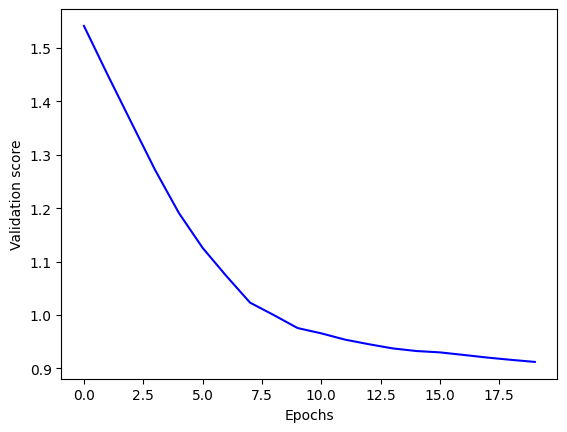

In [5]:
make_history_plot(history1)

### Segundo experimento
(Dense 20 + relu) -> (Dense 30 + relu) + (Dense 30 + softmax)

epochs = 20

In [6]:
%%time
def model_exp2():
    model = Sequential()
    model.add(Dense(20, input_dim=4))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


scores2 = []
for _ in range(20):
    model = model_exp2()
    history2 = model.fit(X_train, y_train, epochs=20, verbose=False)
    y_pred = model.predict(X_test)
    loss_function = Loss_CategoricalCrossentropy()
    loss = loss_function.calculate(y_pred, y_test)
    scores2.append(loss)
    
print("Media", np.mean(scores2))
print("Median", np.median(scores2))
print("Std", np.std(scores2))

2/2 [==============================] - 0s 1ms/step
Media 0.6292021
Median 0.63512766
Std 0.1355475
CPU times: total: 9.91 s
Wall time: 15.1 s


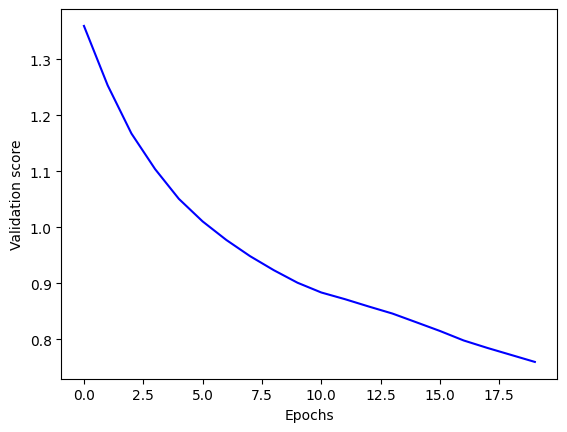

In [8]:
make_history_plot(history2)

### Terceiro experimento
(Dense 20 + relu) -> (Dense 30 + relu) + (Dense 30 + softmax)

epochs = 200

In [9]:
%%time
def model_exp3():
    model = Sequential()
    model.add(Dense(20, input_dim=4))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


scores3 = []
for _ in range(20):
    model = model_exp3()
    history3 = model.fit(X_train, y_train, epochs=200, verbose=False)
    y_pred = model.predict(X_test)
    loss_function = Loss_CategoricalCrossentropy()
    loss = loss_function.calculate(y_pred, y_test)
    scores3.append(loss)
    
print("Media", np.mean(scores3))
print("Median", np.median(scores3))
print("Std", np.std(scores3))

2/2 [==============================] - 0s 1ms/step
Media 0.082608655
Median 0.082032055
Std 0.01289182
CPU times: total: 15.3 s
Wall time: 34.8 s


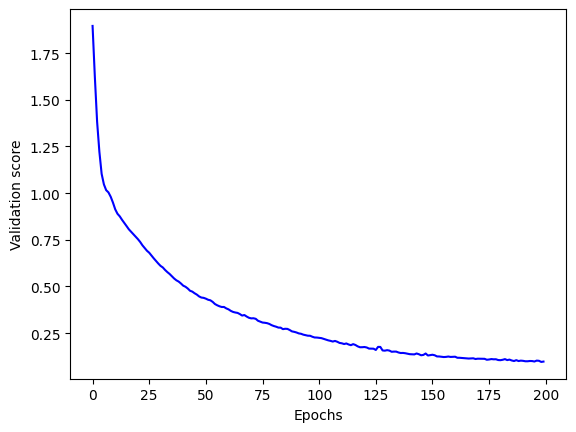

In [10]:
make_history_plot(history3)

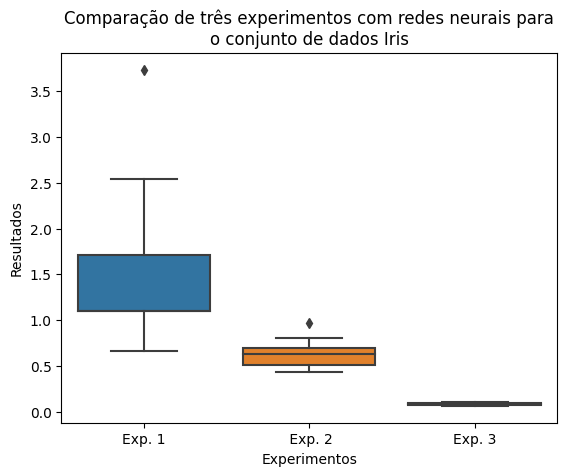

In [13]:
results = pd.DataFrame({
    "Experimentos": 20*['Exp. 1']+20*[' Exp. 2']+20*['Exp. 3'],
    "Resultados": scores1 + scores2 + scores3
})
    

sns.boxplot(data=results, x="Experimentos", y="Resultados")
plt.title("Comparação de três experimentos com redes neurais para\no conjunto de dados Iris")
plt.show()

## Estudo de Caso Titanic: Catboost vs Redes Neurais

In [14]:
X_train, X_test, y_train, y_test = load_preprocess_train_titanic()
model = CatBoostClassifier(verbose=False)
model_fit = model.fit(X_train, y_train)
y_pred = model_fit.predict(X_test)

y_test_encoded = encode_target(y_test)
y_pred_encoded = encode_target(y_pred)
y_train_encoded = encode_target(y_train)

loss_function = Loss_CategoricalCrossentropy()
loss = loss_function.calculate(y_pred_encoded, y_test_encoded)

print(loss)

3.0597062


In [15]:
def keras_model_titanic():
    model = Sequential()
    model.add(Dense(100, input_shape=[7,]))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile('adam','categorical_crossentropy', metrics=['accuracy'])
    return model

model = keras_model_titanic()
hist = model.fit(X_train, y_train_encoded, epochs=250, verbose=0, batch_size=100)

In [16]:
y_pred_encoded = model.predict(X_test)

loss_function = Loss_CategoricalCrossentropy()
loss = loss_function.calculate(y_pred_encoded, y_test_encoded)
print(loss)

10/10 [==============================] - 0s 832us/step
0.41436702


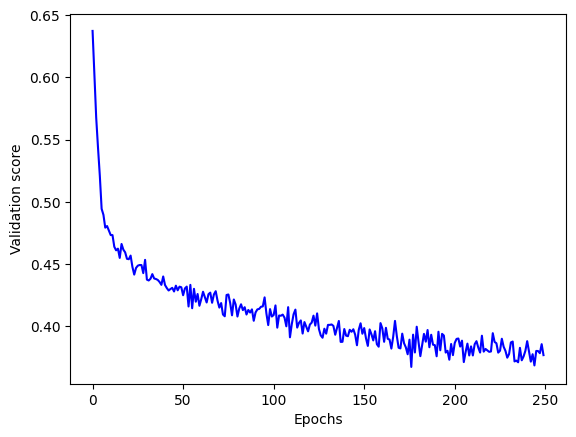

In [17]:
make_history_plot(hist)

## Classificação de imagens

- Desafio no Kaggle: https://www.kaggle.com/competitions/digit-recognizer
- Referência: https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

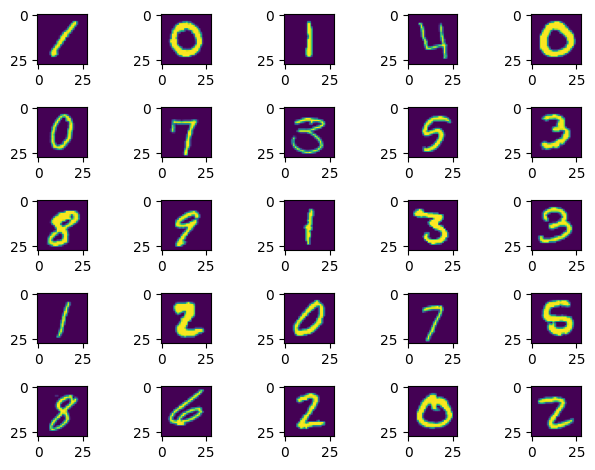

In [18]:
train = pd.read_csv("../datasets/digits/train.csv")
test  = pd.read_csv("../datasets/digits/test.csv")

for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(train.iloc[i-1,1:].values.reshape((28,28)))
plt.tight_layout()
plt.show()

In [19]:
# Get target
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [20]:
def keras_digit_model():

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))

    optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    # Compile the model
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    return model

model = keras_digit_model()
model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                     

In [21]:
%%time
history = model.fit(
    X_train, Y_train, 
    batch_size = 86, 
    epochs = 3, # rise it, if you can
    validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/3
440/440 - 114s - loss: 0.2471 - accuracy: 0.9226 - val_loss: 0.0614 - val_accuracy: 0.9800 - 114s/epoch - 259ms/step
Epoch 2/3
440/440 - 121s - loss: 0.0692 - accuracy: 0.9795 - val_loss: 0.0487 - val_accuracy: 0.9867 - 121s/epoch - 276ms/step
Epoch 3/3
440/440 - 120s - loss: 0.0535 - accuracy: 0.9843 - val_loss: 0.0476 - val_accuracy: 0.9879 - 120s/epoch - 272ms/step
CPU times: total: 13min 44s
Wall time: 5min 55s


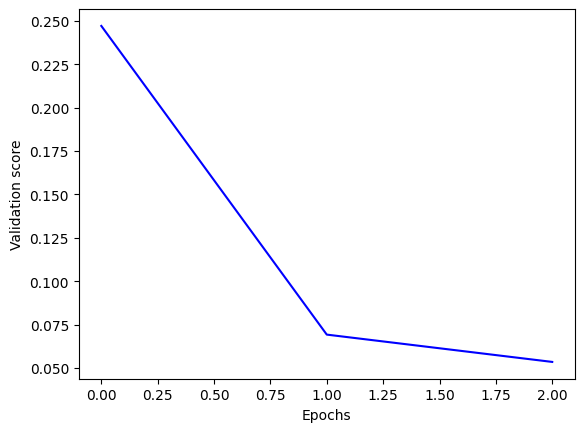

In [22]:
make_history_plot(history)

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Classificação de imagens com data augmentation

### Carregar os dados

In [23]:
train = pd.read_csv("../datasets/digits/train.csv")
test  = pd.read_csv("../datasets/digits/test.csv")

### Preparar os dados

In [24]:
# Get target
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

### Aumentar o volume de dados

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

### Definir o modelo

In [26]:
# mesmo modelo anteriormente usado
model = keras_digit_model()
model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                     

### Treinar o modelo

In [27]:
%%time
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Fit the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size=86),
                              epochs = 3, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 86, # batch_sise
                              callbacks=[learning_rate_reduction])

Epoch 1/3
439/439 - 115s - loss: 0.4103 - accuracy: 0.8690 - val_loss: 0.0754 - val_accuracy: 0.9740 - lr: 0.0010 - 115s/epoch - 263ms/step
Epoch 2/3
439/439 - 107s - loss: 0.1268 - accuracy: 0.9613 - val_loss: 0.0402 - val_accuracy: 0.9895 - lr: 0.0010 - 107s/epoch - 244ms/step
Epoch 3/3
439/439 - 111s - loss: 0.0962 - accuracy: 0.9719 - val_loss: 0.0326 - val_accuracy: 0.9898 - lr: 0.0010 - 111s/epoch - 254ms/step
CPU times: total: 12min 6s
Wall time: 5min 34s


132/132 [==============================] - 2s 13ms/step


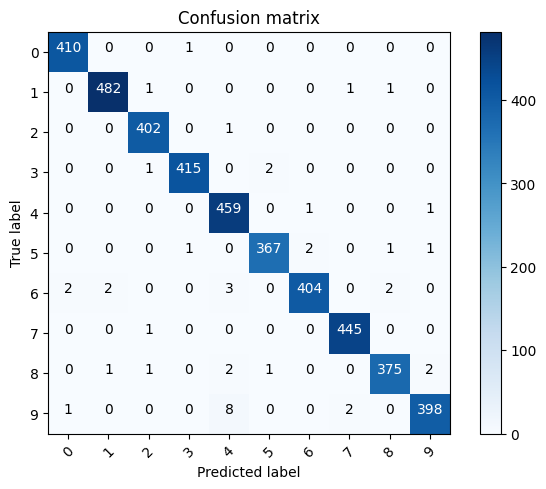

In [28]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Exercício

- Faça uma submissão para o desafio https://www.kaggle.com/competitions/digit-recognizer

<b>Referências</b>

- https://www.youtube.com/playlist?list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3
- https://youtu.be/mFZazxxCKbw